In [1]:
#NOTE: The code below is configured to make running the code possible in Pace-ICE ondemand. You should either change the lines below to reflect your virtual env or comment them out.
import sys
sys.executable = 'miniconda3/envs/DRL/bin/python3.10'
sys.path += ['/home/hice1/jwessell6/DRL/VLMAgent/Gym-Snake', '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10', 
    '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10/site-packages', '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10/lib-dynload', '/home/hice1/jwessell6/.local/bin']

import pandas as pd
import numpy as np
import torch 
#from transformers import AutoProcessor, AutoModelForCausalLM, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig
import pickle
import argparse
import gym
 
from PIL import Image
import matplotlib.pyplot as plt

import gym_snake

/scratch/1014936/ipykernel_2816675/2867124097.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/usr/local/pace-apps/manual/packages/anaconda3/2023.03/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python==0.2.45 --force-reinstall --no-cache-dir
#!wget -O ~/scratch/huggingface/ggml-model-q4_0.gguf https://huggingface.co/remyxai/SpaceLLaVA/resolve/main/ggml-model-q4_0.gguf?download=true
#!wget -O ~/scratch/huggingface/mmproj-model-f16.gguf https://huggingface.co/remyxai/SpaceLLaVA/resolve/main/mmproj-model-f16.gguf?download=true

In [ ]:
'''import sys
sys.executable = 'miniconda3/envs/DRL/bin/python3.10'
sys.path += ['/home/hice1/jwessell6/DRL/VLMAgent/Gym-Snake', '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10', 
    '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10/site-packages', '/home/hice1/jwessell6/miniconda3/envs/DRL/lib/python3.10/lib-dynload', '/home/hice1/jwessell6/.local/bin']
'''
import io
import base64
import numpy as np
import torch
from PIL import Image

from llama_cpp import Llama
from llama_cpp.llama_chat_format import Llava15ChatHandler
#import gym
#import matplotlib.pyplot as plt
#from Gym_Snake import gym_snake
def image_to_base64_data_uri(image_input):
    # Check if the input is a file path (string)
    if isinstance(image_input, str):
        with open(image_input, "rb") as img_file:
            base64_data = base64.b64encode(img_file.read()).decode('utf-8')

    # Check if the input is a PIL Image
    elif isinstance(image_input, Image.Image):
        buffer = io.BytesIO()
        image_input.save(buffer, format="PNG")  # You can change the format if needed
        base64_data = base64.b64encode(buffer.getvalue()).decode('utf-8')

    else:
        raise ValueError("Unsupported input type. Input must be a file path or a PIL.Image.Image instance.")

    return f"data:image/png;base64,{base64_data}"

mmproj="../../scratch/huggingface/ggml-model-q4_0.gguf"
model_path="../../scratch/huggingface/mmproj-model-f16.gguf"
chat_handler = Llava15ChatHandler(clip_model_path=mmproj, verbose=True)
spacellava = Llama(model_path=model_path, chat_handler=chat_handler, n_ctx=2048, logits_all=True, n_gpu_layers = -1)

datasets  ggml-model-q4_0.gguf	hub  mmproj-model-f16.gguf


In [4]:
#model = LlavaOnevisionForConditionalGeneration.from_pretrained("llava-hf/llava-onevision-qwen2-7b-ov-hf", torch_dtype=torch.float16, device_map="auto")
# Load model directly
# Use a pipeline as a high-level helper
processor = AutoProcessor.from_pretrained("remyxai/SpaceLLaVA")
model = AutoModelForCausalLM.from_pretrained("remyxai/SpaceLLaVA")
model.eval()
    #print(model.device)
#processor = AutoProcessor.from_pretrained("llava-hf/llava-onevision-qwen2-7b-ov-hf")

ValueError: Converting from Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast convertors: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']

In [17]:
env = gym.make('snake-v0')
state = env.reset()

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In the game of Snake, the objective is to control a snake that grows as it eats food items, such as cubes, while avoiding the edges of the playing field and its own body. The snake's movement is determined by the direction it is facing, and it will continue in that direction unless it is told to change.

In the image provided, the snake's head is red and its body is black. The blue cube is located to the left of the snake's head, slightly above it. To eat the blue cube, the snake should move in the direction it is currently facing, which appears to be towards the left side of the image. This is because the snake's head is already aligned with the cube, and moving in the same direction would allow the snake to consume the cube without changing its direction.

If the snake were to change direction to try to reach the cube, it would either have to turn around or turn to the right, which would not align

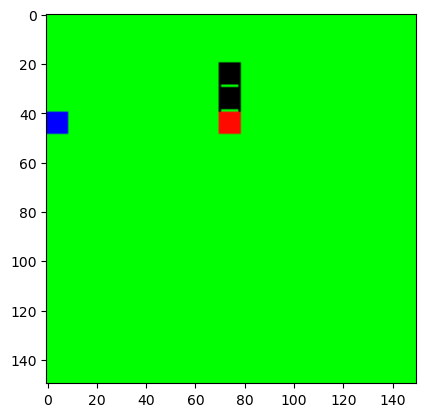

In [18]:
import utils
%load_ext autoreload
%autoreload 2

image = state
plt.imshow(image)
images = [image]#[eg_img, image]
chat = utils.make_conversation(0, "snake-v0","") #eg_txt)
prompt = processor.apply_chat_template(chat, add_generation_prompt=True)
inputs = processor(images=images, text=prompt, return_tensors="pt").to("cuda:0", torch.float16)
output = model.generate(**inputs, max_new_tokens=500)
instruction = processor.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=True)
print(instruction)
action = utils.decode("snake-v0", instruction[len(inputs) : ].lower())
print(action)
state, reward, done, trunc = env.step(action)

In [11]:

#new_
#print(new_state)
#print(reward)
#print(done)
#print(trunc)

0
1627
right
1
